In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1,'/home/jovyan/test_surge_models/surgeNN')
sys.path.insert(0,'/home/jovyan/test_surge_models/projectESL')
import os
from surgeNN.io import load_predictors
from surgeNN.preprocessing import deseasonalize_da
from esl_analysis import guess_initial_gpd_params
from scipy.stats import genpareto
import datetime as dt

2025-07-02 12:57:27.291784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-02 12:57:27.363214: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


xr.Dataset(data_vars=dict(a=(['time'],np.zeros(len(nn_converted.time)))),
            coords=dict(
        time=nn_converted.time.dt.round('10min')
    ),
          ).to_netcdf('3hourly_360day_timesteps_at_julian_calendar_10minRounded.nc')

In [2]:
nn = xr.open_dataset('/home/jovyan/test_surge_models/results/nn_tests/highresmip_predictions/HadGEM3-GC31-HM_lstm_minRMSE_predictions_alpha0.nc').load()
#nn = xr.open_dataset('/home/jovyan/test_surge_models/results/mlr_4x4/highresmip_predictions/HadGEM3-GC31-HM_mlr_predictions.nc').load()
gtsm = xr.open_dataset('/home/jovyan/test_surge_models/GTSM_HighResMIP_HadGEM3_GC31_HM_at_gesla3_tgs_eu_3hourly_360day.nc').load()
tg_coords = xr.open_dataset('/home/jovyan/test_surge_models/gesla3_tg_coordinates_eu.nc')
gtsm['tg'] = tg_coords.tg
gtsm = gtsm.sel(tg=nn.tg)


#gtsm = gtsm.where(np.mod(gtsm.time.dt.hour,3)==0,drop=True)

#gtsm = gtsm.sel(time=gtsm.time[np.where((np.isfinite(gtsm.surge)).all(axis=1))[0]])

gtsm['surge'] = gtsm['surge'].groupby(gtsm.time.dt.year) - gtsm.surge.groupby(gtsm.time.dt.year).mean('time')
gtsm['surge']= deseasonalize_da(gtsm.surge)

#time stretching:
reftime = dt.datetime(1950,1,1)
time0 = nn.time[0]
nn_times = nn.time.values

hours_since_ref_time = 27+((nn.time - nn.time[0]).values/np.timedelta64(1, 'h')) #hours since first of januari 1950 0:00

newdates=[]
for t,time in enumerate(nn_times):
    this_yr = time.year
    actual_days_in_year = pd.Timestamp(this_yr, 12, 31).dayofyear
    
    fraction_of_360yr = hours_since_ref_time[t]/24 - 360 * (this_yr - reftime.year) #fraction of 360days
    
    if fraction_of_360yr == 0:
        newdate = dt.datetime(this_yr,1,1)
    elif 0 < fraction_of_360yr < 360:
        newdate = dt.datetime(this_yr,1,1) + dt.timedelta(days=actual_days_in_year/360 * fraction_of_360yr) #stretch
    else:
        raise Exception('this should not happen')
    newdates.append(newdate)
    
#create new nn dataset with stretched timesteps
nn_converted = nn.copy(deep=True)
nn_converted['time'] = newdates

times = nn_converted.time.values
minutes = nn_converted.time.dt.minute.values
seconds = nn_converted.time.dt.second.values
rounded_dates = []
for t,time in enumerate(times):

    discard =  np.timedelta64(int(minutes[t]) % 10, 'm') + np.timedelta64(seconds=seconds[t],'s')
    x = time-discard
    if discard >= np.timedelta64(5, 'm'):
        time += np.timedelta64(10, 'm')
    rounded_dates.append(x)

dates_intersection = np.intersect1d(nn_converted.time,gtsm.time)
nn_converted = nn_converted.sel(time=dates_intersection)
gtsm = gtsm.sel(time=dates_intersection)

both_finite = np.where((np.isfinite(gtsm.surge.values) & np.isfinite(nn_converted.surge.values)).all(axis=-1))[0]
gtsm = gtsm.isel(time=both_finite)
nn_converted = nn_converted.isel(time=both_finite)

nn_converted['surge_standardized'] = (nn_converted['surge'] - nn_converted['surge'].mean(dim='time'))/nn_converted['surge'].std(dim='time',ddof=0)
gtsm['surge_standardized'] = (gtsm['surge'] - gtsm['surge'].mean(dim='time'))/gtsm['surge'].std(dim='time',ddof=0)

SyntaxError: positional argument follows keyword argument (1122431348.py, line 48)

In [111]:
rounded_dates[0:10]

[numpy.datetime64('1950-01-02T03:20:30.000000000'),
 numpy.datetime64('1950-01-02T06:20:00.000000000'),
 numpy.datetime64('1950-01-02T09:20:30.000000000'),
 numpy.datetime64('1950-01-02T12:30:00.000000000'),
 numpy.datetime64('1950-01-02T15:30:30.000000000'),
 numpy.datetime64('1950-01-02T18:30:00.000000000'),
 numpy.datetime64('1950-01-02T21:30:30.000000000'),
 numpy.datetime64('1950-01-03T00:40:00.000000000'),
 numpy.datetime64('1950-01-03T03:40:30.000000000'),
 numpy.datetime64('1950-01-03T06:40:00.000000000')]

In [110]:
times[0:10]

array(['1950-01-02T03:22:30.000000000', '1950-01-02T06:25:00.000000000',
       '1950-01-02T09:27:30.000000000', '1950-01-02T12:30:00.000000000',
       '1950-01-02T15:32:30.000000000', '1950-01-02T18:35:00.000000000',
       '1950-01-02T21:37:30.000000000', '1950-01-03T00:40:00.000000000',
       '1950-01-03T03:42:30.000000000', '1950-01-03T06:45:00.000000000'],
      dtype='datetime64[ns]')

In [55]:
tg = 'esbjerg-esb-dnk-dmi.csv'

periods = [slice('1950','1980'),slice('1985','2015'),slice('2020','2050')]
nn_extremes_in_period = []
gtsm_extremes_in_period = []

nn_extremes_freq_in_period = []
gtsm_extremes_freq_in_period = []

for period in periods:
    nn_surge = nn_converted.sel(tg=tg).surge_standardized.sel(time=period)
    gtsm_surge = gtsm.sel(tg=tg).surge_standardized.sel(time=period)
    
    nn_surge = np.isfinite(
    
    nn_extremes = nn_converted.sel(tg=tg).surge_standardized.sel(time=period).where(nn_converted.sel(tg=tg).surge_standardized.sel(time=period)>nn_converted.sel(tg=tg).surge_standardized.sel(time=period).quantile(.99,dim='time')).values
    gtsm_extremes = gtsm.sel(tg=tg).surge_standardized.sel(time=period).where(gtsm.sel(tg=tg).surge_standardized.sel(time=period)>gtsm.sel(tg=tg).surge_standardized.sel(time=period).quantile(.99,dim='time')).values

    #to-do: decluster
    nn_extremes_freq = [np.nansum(nn_extremes>=k)/len(nn_extremes) for k in nn_extremes]
    gtsm_extremes_freq = [np.nansum(gtsm_extremes>=k)/len(gtsm_extremes) for k in gtsm_extremes]
    
    nn_extremes_in_period.append(nn_extremes)
    gtsm_extremes_in_period.append(gtsm_extremes)
    
    nn_extremes_freq_in_period.append(nn_extremes_freq)
    gtsm_extremes_freq_in_period.append(gtsm_extremes_freq)
    

SyntaxError: '(' was never closed (487594367.py, line 14)

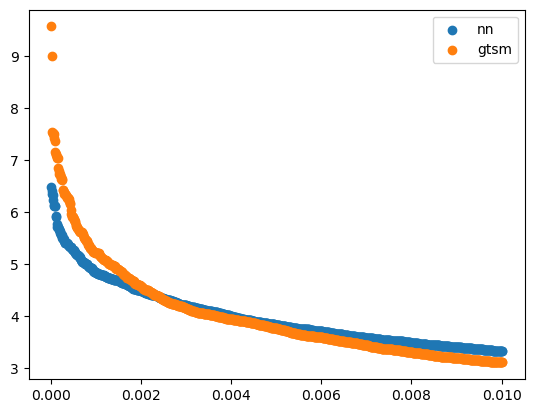

In [8]:
plt.figure()
plt.scatter(nn_extremes_freq_in_period[0],nn_extremes_in_period[0],label='nn')
plt.scatter(gtsm_extremes_freq_in_period[0],gtsm_extremes_in_period[0],label='gtsm')
plt.legend()

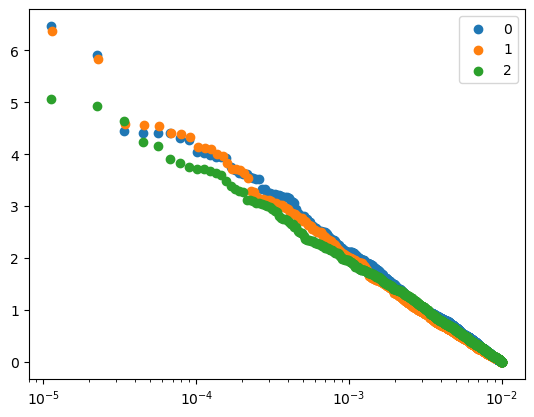

In [19]:
plt.figure()
plt.scatter(gtsm_extremes_freq_in_period[0],gtsm_extremes_in_period[0]-np.nanmin(gtsm_extremes_in_period[0]),label='0')
plt.scatter(gtsm_extremes_freq_in_period[1],gtsm_extremes_in_period[1]-np.nanmin(gtsm_extremes_in_period[1]),label='1')
plt.scatter(gtsm_extremes_freq_in_period[2],gtsm_extremes_in_period[2]-np.nanmin(gtsm_extremes_in_period[2]),label='2')
plt.xscale('log')
plt.legend()

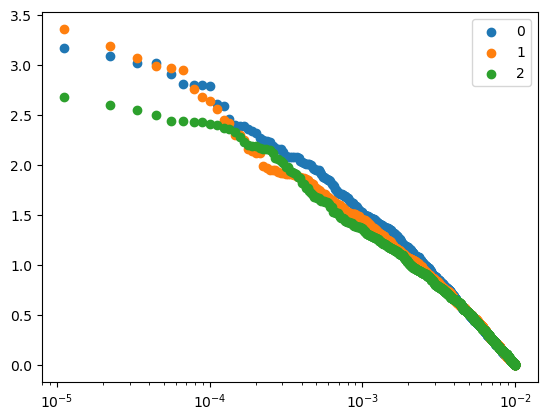

In [20]:
plt.figure()
plt.scatter(nn_extremes_freq_in_period[0],nn_extremes_in_period[0]-np.nanmin(nn_extremes_in_period[0]),label='0')
plt.scatter(nn_extremes_freq_in_period[1],nn_extremes_in_period[1]-np.nanmin(nn_extremes_in_period[1]),label='1')
plt.scatter(nn_extremes_freq_in_period[2],nn_extremes_in_period[2]-np.nanmin(nn_extremes_in_period[2]),label='2')
plt.xscale('log')
plt.legend()

In [5]:
nn_yrfraction_extreme = (nn_converted.surge>=nn_converted.surge.quantile(.99,dim='time')).groupby(nn_converted.time.dt.year).sum()/(np.isfinite(nn_converted.surge)).groupby(nn_converted.time.dt.year).sum()
gtsm_yrfraction_extreme = (gtsm.surge>=gtsm.surge.quantile(.99,dim='time')).groupby(gtsm.time.dt.year).sum()/(np.isfinite(gtsm.surge)).groupby(gtsm.time.dt.year).sum()

nn_99pct_of_year = nn_converted.surge.groupby(nn_converted.time.dt.year).quantile(.99)
gtsm_99pct_of_year = gtsm.surge.groupby(gtsm.time.dt.year).quantile(.99)

Text(0, 0.5, 'fraction of 99th percentile exceedances in year')

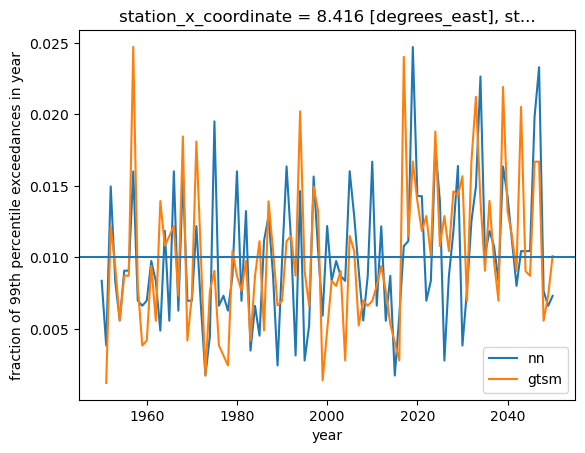

In [6]:
nn_yrfraction_extreme.sel(tg='esbjerg-esb-dnk-dmi.csv').plot(label='nn')
gtsm_yrfraction_extreme.sel(tg='esbjerg-esb-dnk-dmi.csv').plot(label='gtsm')
plt.axhline(y=0.01)
plt.legend()
plt.ylabel('fraction of 99th percentile exceedances in year')

Text(0, 0.5, 'fraction of 99th percentile exceedances in year')

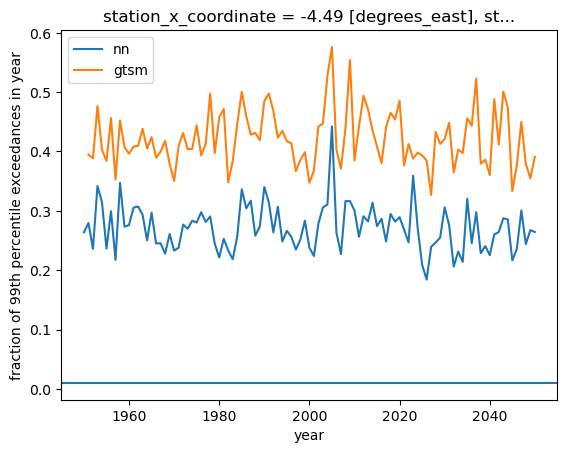

In [7]:
nn_99pct_of_year.sel(tg='brest-822a-fra-uhslc.csv').plot(label='nn')
gtsm_99pct_of_year.sel(tg='brest-822a-fra-uhslc.csv').plot(label='gtsm')
plt.axhline(y=0.01)
plt.legend()
plt.ylabel('fraction of 99th percentile exceedances in year')
#kind of strange that everything after 2016 is much larger??

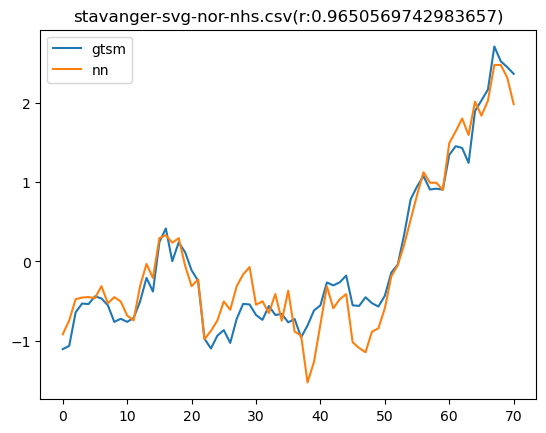

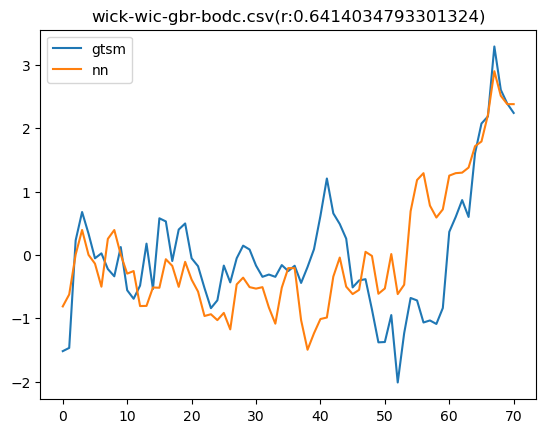

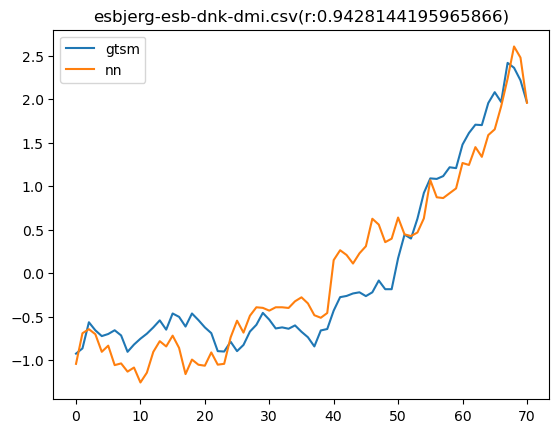

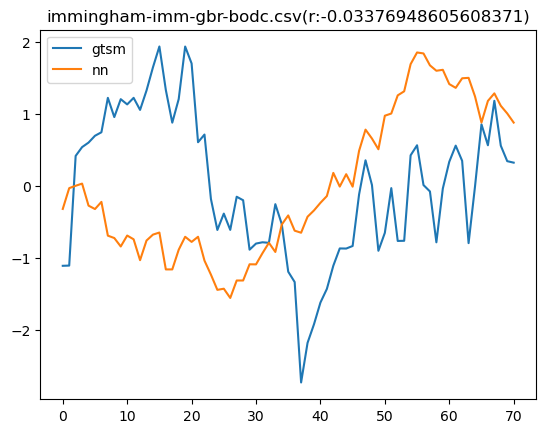

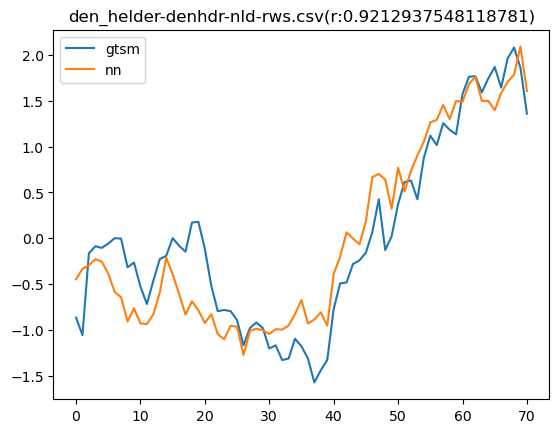

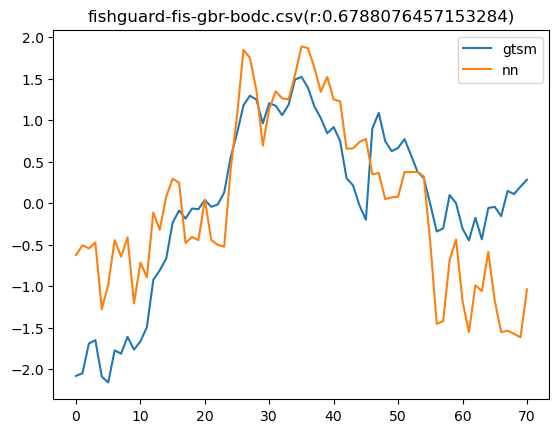

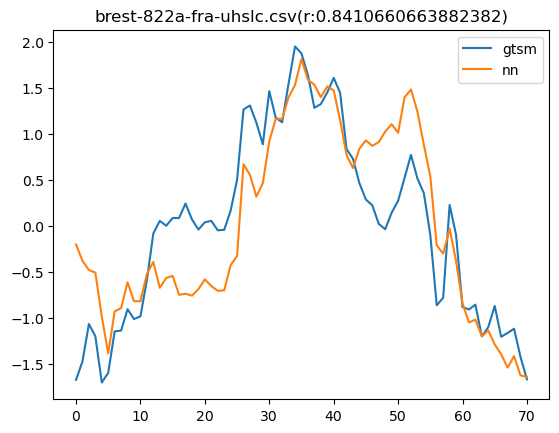

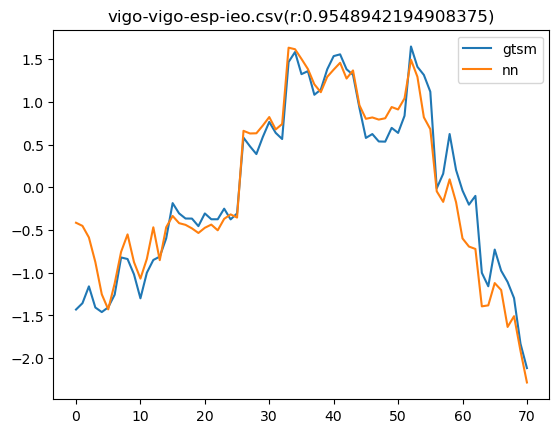

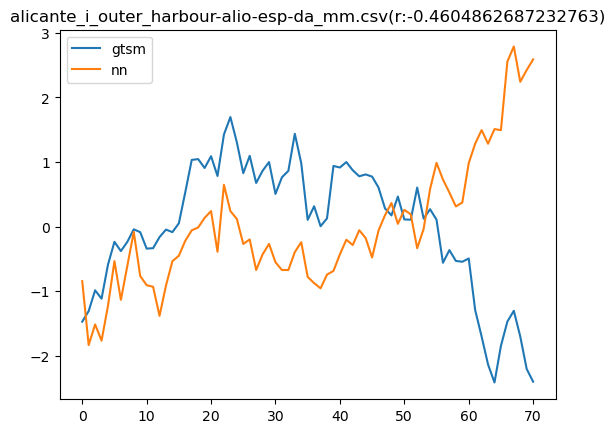

In [8]:
tgs        = ['stavanger-svg-nor-nhs.csv','wick-wic-gbr-bodc.csv','esbjerg-esb-dnk-dmi.csv',
                  'immingham-imm-gbr-bodc.csv','den_helder-denhdr-nld-rws.csv', 'fishguard-fis-gbr-bodc.csv',  
                  'brest-822a-fra-uhslc.csv', 'vigo-vigo-esp-ieo.csv',  'alicante_i_outer_harbour-alio-esp-da_mm.csv']
for tg in tgs:
    years = [np.arange(k,k+30) for k in np.arange(1950,2050+1-30)]
    pct99_gtsm = [float(gtsm.surge.sel(time=slice(str(k[0]),str(k[-1]))).sel(tg=tg).quantile(.99,dim='time').values) for k in years]
    pct99_nn = [float(nn_converted.surge.sel(time=slice(str(k[0]),str(k[-1]))).sel(tg=tg).quantile(.99,dim='time').values) for k in years]
    plt.figure()
    plt.plot((np.array(pct99_gtsm)-np.mean(pct99_gtsm))/np.std(pct99_gtsm,ddof=0),label='gtsm')
    plt.plot((np.array(pct99_nn)-np.mean(pct99_nn))/np.std(pct99_nn,ddof=0),label='nn')
    plt.title(tg+'(r:'+str(np.corrcoef(pct99_gtsm,pct99_nn)[0][1])+')')
    plt.legend()

In [9]:
tgs        = ['stavanger-svg-nor-nhs.csv','wick-wic-gbr-bodc.csv','esbjerg-esb-dnk-dmi.csv',
                  'immingham-imm-gbr-bodc.csv','den_helder-denhdr-nld-rws.csv', 'fishguard-fis-gbr-bodc.csv',  
                  'brest-822a-fra-uhslc.csv', 'vigo-vigo-esp-ieo.csv',  'alicante_i_outer_harbour-alio-esp-da_mm.csv']
for tg in tgs:
    years = [np.arange(k,k+30) for k in np.arange(1950,2050+1-30)]
    pct99_gtsm = [float(gtsm.surge.sel(time=slice(str(k[0]),str(k[-1]))).sel(tg=tg).quantile(.99,dim='time').values) for k in years]
    pct99_nn = [float(nn_converted.surge.sel(time=slice(str(k[0]),str(k[-1]))).sel(tg=tg).quantile(.99,dim='time').values) for k in years]
    print(tg+' '+str(np.corrcoef(pct99_gtsm,pct99_nn)[0][1]))

stavanger-svg-nor-nhs.csv 0.9650569742983657
wick-wic-gbr-bodc.csv 0.6414034793301324
esbjerg-esb-dnk-dmi.csv 0.9428144195965866
immingham-imm-gbr-bodc.csv -0.03376948605608371
den_helder-denhdr-nld-rws.csv 0.9212937548118781
fishguard-fis-gbr-bodc.csv 0.6788076457153284
brest-822a-fra-uhslc.csv 0.8410660663882382
vigo-vigo-esp-ieo.csv 0.9548942194908375
alicante_i_outer_harbour-alio-esp-da_mm.csv -0.4604862687232763


In [11]:
np.corrcoef(pct99_gtsm,pct99_nn)

array([[1.        , 0.78031578],
       [0.78031578, 1.        ]])

In [25]:
a=nn_99pct_of_year.sel(tg='esbjerg-esb-dnk-dmi.csv')
b=gtsm_99pct_of_year.sel(tg='esbjerg-esb-dnk-dmi.csv')

np.corrcoef(a.sel(year=b.year).sel(year=slice('2015','2050')),b.sel(year=slice('2015','2050')))

NameError: name 'nn_99pct_of_year' is not defined

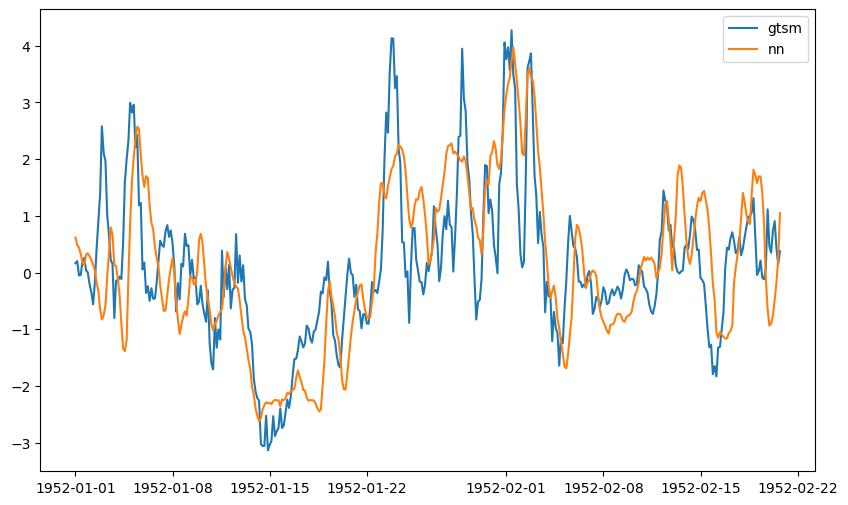

In [18]:
year = '1952'
tg_to_plot='den_helder-denhdr-nld-rws.csv'
gtsm_standardized = ((gtsm.sel(tg=tg_to_plot).surge - np.mean(gtsm.sel(tg=tg_to_plot).surge))/np.std(gtsm.sel(tg=tg_to_plot).surge,ddof=0))
nn_standardized = ((nn_converted.sel(tg=tg_to_plot).surge-nn_converted.y_train_mean.sel(tg=tg_to_plot))/nn_converted.y_train_sd.sel(tg=tg_to_plot))
plt.figure(figsize=(10,6))
plt.plot(gtsm_standardized.sel(time=slice(year,year)).time[0:400],gtsm_standardized.sel(time=slice(year,year))[0:400],label='gtsm')
plt.plot(nn_standardized.sel(time=slice(year,year)).time[0:400],nn_standardized.sel(time=slice(year,year))[0:400],label='nn')
#plt.plot(nn_standardized[61150:61350].time,nn_standardized[71150:71350],label='nn')

plt.legend()

In [17]:
np.corrcoef(gtsm.sel(tg='den_helder-denhdr-nld-rws.csv').surge,nn_converted.sel(tg='den_helder-denhdr-nld-rws.csv').surge)

array([[1.        , 0.51582366],
       [0.51582366, 1.        ]])

<xarray.DataArray 'surge' (time: 2920)>
array([-1.62427957, -1.18697799, -1.18345141, ..., -2.25426269,
       -2.40238093, -2.10967102])
Coordinates:
  * time                  (time) datetime64[ns] 2010-01-01 ... 2010-12-31T21:...
    station_x_coordinate  float64 4.739
    station_y_coordinate  float64 52.96
    lon                   float64 4.745
    lat                   float64 52.96
    tg                    <U29 'den_helder-denhdr-nld-rws.csv'
    i_lstm                float64 17.0
    it_lstm               float64 4.0
    year                  (time) int64 2010 2010 2010 2010 ... 2010 2010 2010
    month                 (time) int64 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12

Text(0.5, 1.0, 'snapshot at den_helder-denhdr-nld-rws.csv')

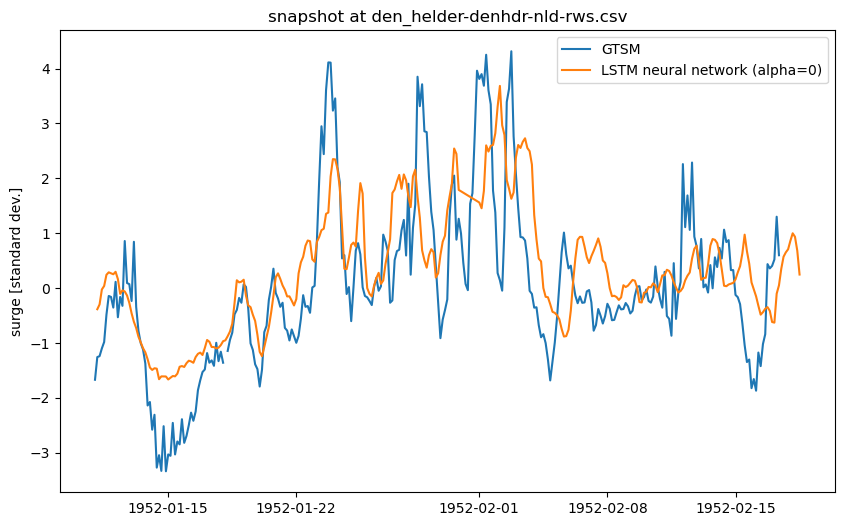

In [56]:
plt.figure(figsize=(10,6))
plt.plot(gtsm_standardized.time[3000:3300],gtsm_standardized[3000:3300],label='GTSM')
plt.plot(nn_standardized[5800:6100].time,nn_standardized[5800:6100],label='LSTM neural network (alpha=0)')
#plt.plot(nn_standardized[61150:61350].time,nn_standardized[71150:71350],label='nn')
plt.ylabel('surge [standard dev.]')
plt.legend()
plt.title('snapshot at '+tg_to_plot)

Text(0.5, 1.0, 'snapshot at den_helder-denhdr-nld-rws.csv')

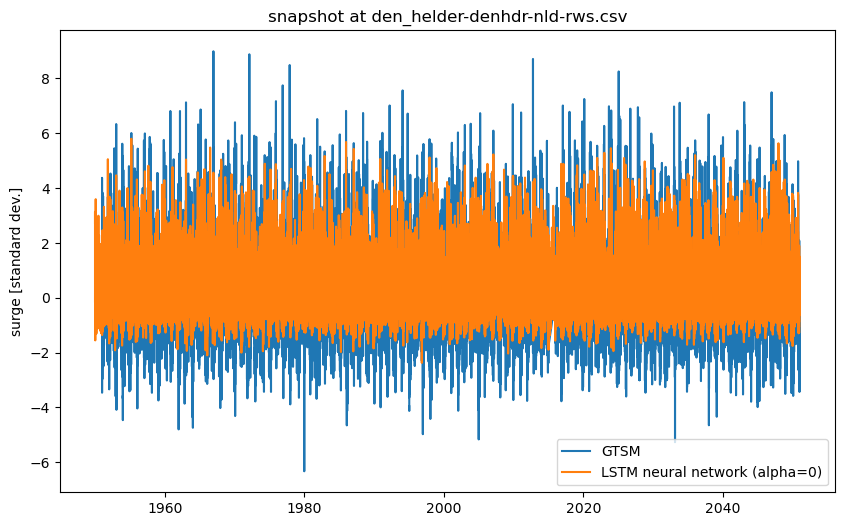

In [57]:
plt.figure(figsize=(10,6))
plt.plot(gtsm_standardized.time,gtsm_standardized,label='GTSM')
plt.plot(nn_standardized.time,nn_standardized,label='LSTM neural network (alpha=0)')
#plt.plot(nn_standardized[61150:61350].time,nn_standardized[71150:71350],label='nn')
plt.ylabel('surge [standard dev.]')
plt.legend()
plt.title('snapshot at '+tg_to_plot)

In [5]:
test= xr.open_dataset('/home/jovyan/test_surge_models/GTSM_HighResMIP_HadGEM3_GC31_HM_at_gesla3_tgs_eu_hourly_anoms.nc').load()

In [6]:
test = test.where(np.mod(test.time.dt.hour,3)==0,drop=True)

In [18]:
test.convert_calendar('360_day',align_on='year').sel(tg='den_helder-denhdr-nld-rws.csv').surge[0:248]

<xarray.DataArray 'surge' (time: 248)>
array([-0.193     , -0.02      ,  0.15      ,  0.15      ,  0.264     ,
        0.19700001, -0.021     , -0.068     , -0.119     , -0.07600001,
       -0.053     ,  0.09500001,  0.104     ,  0.13000001,  0.068     ,
        0.28100002,  0.18      ,  0.18400002,  0.08400001,  0.261     ,
        0.071     ,  0.051     ,  0.07300001,  0.314     ,  0.16700001,
        0.39200002,  0.41400003,  0.674     ,  0.45400003,  0.354     ,
        0.23600002,  0.16100001,  0.34600002,  0.30600002,  0.58100003,
        0.68      ,  1.3110001 ,  1.0170001 ,  0.76100004,  0.554     ,
        0.57100004,  0.264     ,  0.006     , -0.07300001, -0.18900001,
       -0.28800002, -0.51000005, -0.606     , -0.73300004, -0.684     ,
       -0.832     , -0.83000004, -0.9110001 , -0.74200004, -0.804     ,
       -0.76000005, -0.791     , -0.58400005, -0.63500005, -0.588     ,
       -0.652     , -0.44500002, -0.596     , -0.591     , -0.62100005,
       -0.43300003, -0.48000002, -0.469     , -0.48000002, -0.32500002,
       -0.367     , -0.381     , -0.36400002, -0.32200003, -0.30400002,
       -0.34      , -0.323     , -0.238     , -0.22200002, -0.22500001,
       -0.2       , -0.14      , -0.148     , -0.136     , -0.134     ,
       -0.09      , -0.11400001, -0.134     , -0.17      , -0.12200001,
       -0.18      , -0.12900001, -0.126     , -0.08800001, -0.15300001,
       -0.143     , -0.19600001, -0.19600001, -0.25500003, -0.24400002,
...
       -0.33100003, -0.282     , -0.38500002, -0.192     , -0.19500001,
       -0.186     , -0.317     , -0.127     , -0.097     , -0.06900001,
       -0.13700001, -0.064     , -0.062     , -0.014     , -0.05      ,
       -0.009     , -0.03      , -0.049     , -0.10700001, -0.11100001,
       -0.12      , -0.055     ,  0.006     ,  0.015     ,  0.07600001,
        0.031     , -0.01      , -0.2       , -0.17500001, -0.21400002,
       -0.18300001, -0.307     , -0.185     , -0.17600001, -0.14400001,
       -0.23300001, -0.109     ,  0.        ,  0.08800001,  0.023     ,
        0.10300001,  0.062     ,  0.054     , -0.017     ,  0.066     ,
        0.16100001,  0.224     ,  0.29000002,  0.28      ,  0.37100002,
        0.298     ,  0.24700001,  0.22900002,  0.38200003,  0.397     ,
        0.45200002,  0.379     ,  0.50200003,  0.45000002,  0.47700003,
        0.66200006,  1.1580001 ,  1.0630001 ,  1.087     ,  0.65400004,
        0.36200002, -0.071     , -0.163     , -0.257     , -0.22600001,
       -0.075     ,  0.038     ,  0.14      ,  0.194     ,  0.22800002,
        0.24400002,  0.29500002,  0.36      ,  0.39400002,  0.40500003,
        0.303     ,  0.268     ,  0.15300001,  0.108     , -0.007     ,
       -0.025     , -0.062     , -0.022     ,  0.017     ,  0.019     ,
        0.053     ,  0.081     ,  0.18100001,  0.291     ,  0.44200003,
        0.43500003,  0.549     ,  0.592     ], dtype=float32)
Coordinates:
  * time                  (time) object 1951-01-01 00:00:00 ... 1951-02-01 21...
    station_x_coordinate  float64 4.739
    station_y_coordinate  float64 52.96
    lon                   float64 4.745
    lat                   float64 52.96
    tg                    <U29 'den_helder-denhdr-nld-rws.csv'
Attributes:
    long_name:      storm_surge
    units:          m
    CDI_grid_type:  unstructured
    short_name:     storm_surge
    description:    Surge signal resulting from subtracting water level and t...

In [35]:
gtsm = xr.open_dataset('/home/jovyan/test_surge_models/GTSM_HighResMIP_HadGEM3_GC31_HM_at_gesla3_tgs_eu_hourly_anoms.nc').load()
gtsm = gtsm.sel(tg=nn.tg)
gtsm = gtsm.where(np.mod(gtsm.time.dt.hour,3)==0,drop=True)
gtsm['surge'] = gtsm['surge'].groupby(gtsm.time.dt.year) - gtsm.surge.groupby(gtsm.time.dt.year).mean('time')
gtsm['surge']= deseasonalize_da(gtsm.surge)

gtsm = gtsm.convert_calendar('360_day',align_on='date')

In [40]:
gtsm.surge[260:465]

<xarray.DataArray 'surge' (time: 205, tg: 9)>
array([[-0.1043808 , -0.2980052 , -0.22283684, ..., -0.10146957,
        -0.19145651, -0.22399457],
       [-0.0963808 , -0.24500518, -0.26883686, ..., -0.12746957,
        -0.1374565 , -0.19299456],
       [-0.09438081, -0.12100519, -0.33883685, ..., -0.14446957,
        -0.04545651, -0.20699456],
       ...,
       [ 0.08461921,  0.30299482,  1.0511633 , ...,  0.08753044,
         0.16354351,  0.10800546],
       [ 0.09261921,  0.10199482,  0.5141632 , ...,  0.17853044,
         0.12654349,  0.14500545],
       [ 0.07326619,  0.15991646,  0.6414704 , ...,  0.18351403,
         0.16538864,  0.12270627]], dtype=float32)
Coordinates:
  * time                  (time) object 1951-02-03 12:00:00 ... 1951-03-01 00...
    station_x_coordinate  (tg) float64 -0.476 -4.49 4.739 ... -8.738 -3.069
    station_y_coordinate  (tg) float64 38.33 48.38 52.96 ... 58.97 42.24 58.43
    lon                   (tg) float64 -0.4779 -4.495 4.745 ... -8.73 -3.086
    lat                   (tg) float64 38.34 48.38 52.96 ... 58.97 42.24 58.44
  * tg                    (tg) object 'alicante_i_outer_harbour-alio-esp-da_m...
    i_lstm                (tg) float64 21.0 15.0 17.0 22.0 ... 21.0 22.0 21.0
    it_lstm               (tg) float64 1.0 0.0 4.0 3.0 2.0 0.0 0.0 0.0 0.0
    year                  (time) int64 1951 1951 1951 1951 ... 1951 1951 1951
    month                 (time) int64 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 3

In [42]:
mm=np.intersect1d(nn.time,gtsm.time)

In [29]:
test.sel(tg='den_helder-denhdr-nld-rws.csv').surge[250:475]

<xarray.DataArray 'surge' (time: 225)>
array([ 0.66700006,  0.517     ,  0.46      ,  0.18100001,  0.202     ,
       -0.005     , -0.126     , -0.23300001, -0.14500001,  0.059     ,
        0.015     ,  0.15300001,  0.14600001,  0.179     ,  0.014     ,
       -0.012     , -0.109     , -0.10700001, -0.209     , -0.25500003,
       -0.32500002, -0.29900002, -0.43800002, -0.356     , -0.37100002,
       -0.284     , -0.21100001, -0.13000001, -0.033     ,  0.017     ,
        0.057     , -0.012     , -0.022     , -0.002     ,  0.029     ,
       -0.006     , -0.005     , -0.002     , -0.009     , -0.132     ,
       -0.097     , -0.067     , -0.05      , -0.155     , -0.044     ,
       -0.033     , -0.037     , -0.24900001, -0.15400001, -0.162     ,
       -0.109     , -0.28500003, -0.078     , -0.033     ,  0.008     ,
       -0.049     , -0.027     , -0.056     , -0.016     , -0.068     ,
       -0.025     , -0.056     , -0.042     , -0.079     , -0.093     ,
       -0.11400001, -0.057     , -0.047     , -0.028     , -0.013     ,
        0.021     ,  0.029     , -0.037     ,  0.01      ,  0.029     ,
        0.027     , -0.09500001, -0.08400001, -0.05      , -0.06500001,
       -0.20300001, -0.08800001, -0.037     ,  0.        , -0.126     ,
        0.047     ,  0.12      ,  0.12      , -0.051     ,  0.105     ,
        0.17600001,  0.21700001,  0.022     ,  0.15      ,  0.067     ,
        0.031     , -0.216     , -0.14400001, -0.20700002, -0.15400001,
...
       -0.10200001, -0.057     ,  0.12400001,  0.19100001,  0.32200003,
        0.273     ,  0.164     ,  0.165     ,  0.24200001,  0.2       ,
        0.119     ,  0.12      ,  0.119     ,  0.162     ,  0.246     ,
        0.32900003,  0.42000002,  0.38300002,  0.384     ,  0.30200002,
        0.335     ,  0.305     ,  0.40600002,  0.26200002,  0.25100002,
        0.16600001,  0.194     ,  0.125     ,  0.142     ,  0.15900001,
        0.08800001,  0.014     , -0.005     ,  0.10600001,  0.037     ,
        0.1       ,  0.078     ,  0.25      ,  0.083     ,  0.09      ,
        0.009     ,  0.27100003, -0.018     ,  0.038     ,  0.029     ,
        0.416     ,  0.09500001,  0.119     ,  0.026     ,  0.26900002,
        0.08400001,  0.086     ,  0.045     ,  0.11700001,  0.066     ,
        0.09900001,  0.062     ,  0.115     ,  0.062     ,  0.132     ,
        0.11300001,  0.08800001,  0.029     ,  0.013     , -0.026     ,
        0.023     ,  0.10700001,  0.30100003,  0.35200003,  0.42800003,
        0.32200003,  0.33200002,  0.141     ,  0.11000001,  0.072     ,
       -0.093     , -0.246     , -0.307     , -0.24900001, -0.45600003,
       -0.56600004, -0.614     , -0.34600002, -0.53000003, -0.469     ,
       -0.48000002, -0.012     , -0.135     ,  0.27800003,  0.372     ,
        1.065     ,  0.528     ,  0.64100003,  0.39800003,  0.532     ],
      dtype=float32)
Coordinates:
  * time                  (time) datetime64[ns] 1951-02-01T06:00:00 ... 1951-...
    station_x_coordinate  float64 4.739
    station_y_coordinate  float64 52.96
    lon                   float64 4.745
    lat                   float64 52.96
    tg                    <U29 'den_helder-denhdr-nld-rws.csv'
Attributes:
    long_name:      storm_surge
    units:          m
    CDI_grid_type:  unstructured
    short_name:     storm_surge
    description:    Surge signal resulting from subtracting water level and t...

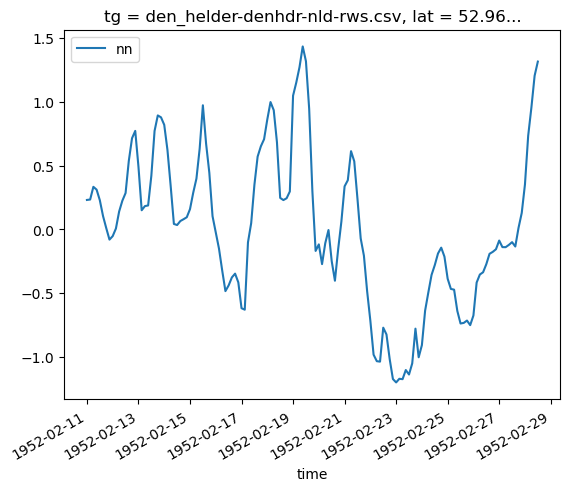

In [3]:
tg_to_plot = 'den_helder-denhdr-nld-rws.csv'
gtsm_standardized = ((gtsm.sel(tg=tg_to_plot).surge - np.mean(gtsm.sel(tg=tg_to_plot).surge))/np.std(gtsm.sel(tg=tg_to_plot).surge,ddof=0))
nn_standardized = ((nn.sel(tg=tg_to_plot).surge-nn.y_train_mean.sel(tg=tg_to_plot))/nn.y_train_sd.sel(tg=tg_to_plot))
#gtsm_standardized.plot(label='gtsm')
nn_standardized[3172:3313].plot(label='nn')
plt.legend()

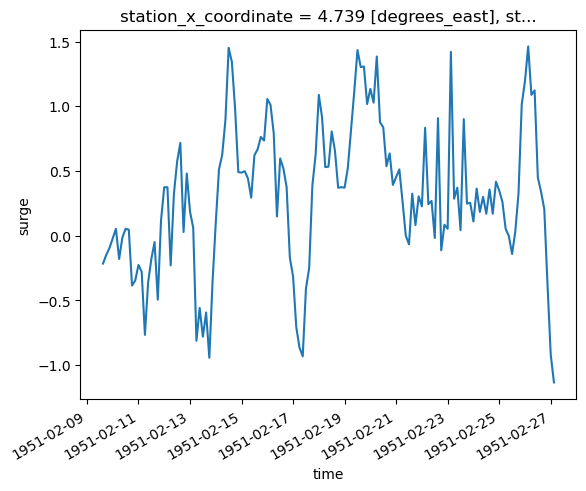

In [4]:
tg_to_plot = 'den_helder-denhdr-nld-rws.csv'
gtsm_standardized = ((gtsm.sel(tg=tg_to_plot).surge - np.mean(gtsm.sel(tg=tg_to_plot).surge))/np.std(gtsm.sel(tg=tg_to_plot).surge,ddof=0))
nn_standardized = ((nn.sel(tg=tg_to_plot).surge-nn.y_train_mean.sel(tg=tg_to_plot))/nn.y_train_sd.sel(tg=tg_to_plot))
gtsm_standardized[309:449].plot(label='gtsm')

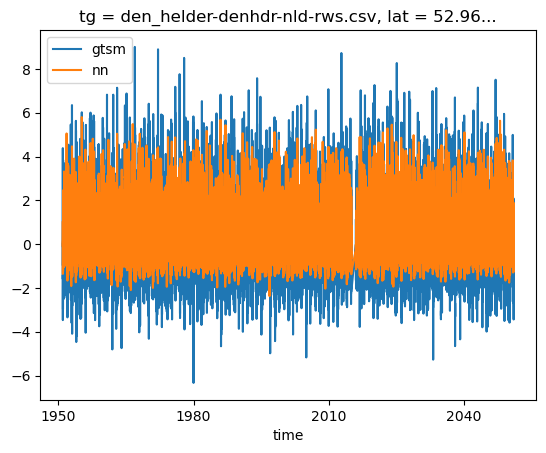

In [4]:
tg_to_plot = 'den_helder-denhdr-nld-rws.csv'

gtsm_standardized = ((gtsm.sel(tg=tg_to_plot).surge - np.mean(gtsm.sel(tg=tg_to_plot).surge))/np.std(gtsm.sel(tg=tg_to_plot).surge,ddof=0))
nn_standardized = ((nn.sel(tg=tg_to_plot).surge-nn.y_train_mean.sel(tg=tg_to_plot))/nn.y_train_sd.sel(tg=tg_to_plot))
gtsm_standardized.plot(label='gtsm')
nn_standardized.plot(label='nn')
plt.legend()

"\ntg_to_plot = 'esbjerg-esb-dnk-dmi.csv'\ngtsm.sel(tg=tg_to_plot).where(gtsm_is_extreme.sel(tg=tg_to_plot),drop=True).surge.plot()\nnn.sel(tg=tg_to_plot).where(gtsm_is_extreme.sel(tg=tg_to_plot),drop=True).surge.plot()\n"

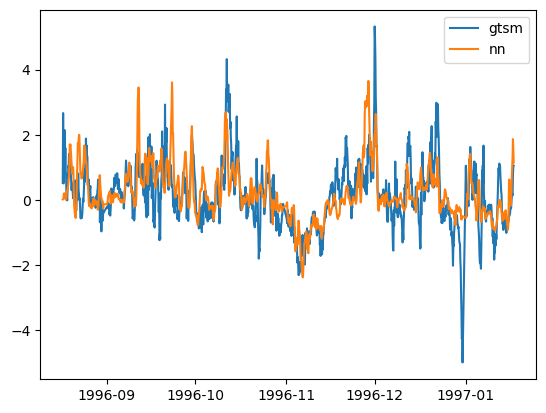

In [4]:
tg_to_plot = 'den_helder-denhdr-nld-rws.csv'

gtsm_standardized = ((gtsm.sel(tg=tg_to_plot).surge - np.mean(gtsm.sel(tg=tg_to_plot).surge))/np.std(gtsm.sel(tg=tg_to_plot).surge,ddof=0))
nn_standardized = ((nn.sel(tg=tg_to_plot).surge-nn.y_train_mean.sel(tg=tg_to_plot))/nn.y_train_sd.sel(tg=tg_to_plot))
plt.plot(gtsm_standardized[130300:131500].time,gtsm_standardized[130300:131500],label='gtsm')
plt.plot(gtsm_standardized[130300:131500].time,nn_standardized[130300:131500],label='nn')
plt.legend()
'''
tg_to_plot = 'esbjerg-esb-dnk-dmi.csv'
gtsm.sel(tg=tg_to_plot).where(gtsm_is_extreme.sel(tg=tg_to_plot),drop=True).surge.plot()
nn.sel(tg=tg_to_plot).where(gtsm_is_extreme.sel(tg=tg_to_plot),drop=True).surge.plot()
'''

"\ntg_to_plot = 'esbjerg-esb-dnk-dmi.csv'\ngtsm.sel(tg=tg_to_plot).where(gtsm_is_extreme.sel(tg=tg_to_plot),drop=True).surge.plot()\nnn.sel(tg=tg_to_plot).where(gtsm_is_extreme.sel(tg=tg_to_plot),drop=True).surge.plot()\n"

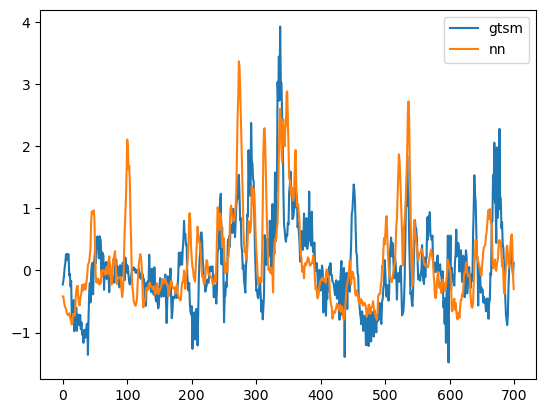

In [11]:
tg_to_plot = 'den_helder-denhdr-nld-rws.csv'

gtsm_standardized = ((gtsm.sel(tg=tg_to_plot).surge - np.mean(gtsm.sel(tg=tg_to_plot).surge))/np.std(gtsm.sel(tg=tg_to_plot).surge,ddof=0))
nn_standardized = ((nn.sel(tg=tg_to_plot).surge-nn.y_train_mean.sel(tg=tg_to_plot))/nn.y_train_sd.sel(tg=tg_to_plot))
#plt.plot(gtsm_standardized[70300:71000].time,gtsm_standardized[70300:71000],label='gtsm')
#plt.plot(gtsm_standardized[70300:71000].time,nn_standardized[70300:71000],label='nn')
plt.plot(gtsm_standardized[70300:71000],label='gtsm')
plt.plot(nn_standardized[70300:71000],label='nn')
plt.legend()
'''
tg_to_plot = 'esbjerg-esb-dnk-dmi.csv'
gtsm.sel(tg=tg_to_plot).where(gtsm_is_extreme.sel(tg=tg_to_plot),drop=True).surge.plot()
nn.sel(tg=tg_to_plot).where(gtsm_is_extreme.sel(tg=tg_to_plot),drop=True).surge.plot()
'''

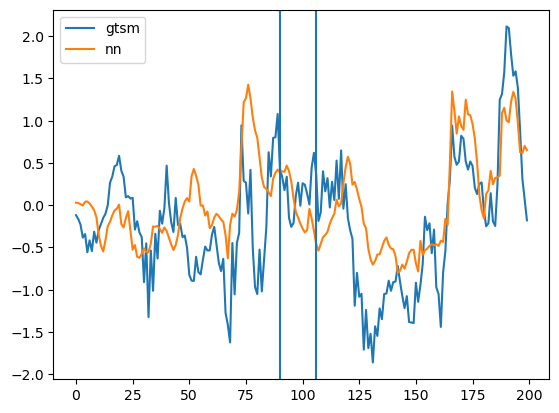

In [31]:
plt.figure()
plt.plot(gtsm_standardized[71150+15:71350+15],label='gtsm')
plt.plot(nn_standardized[71150:71350],label='nn')
plt.axvline(x=90)
plt.axvline(x=106)
plt.legend()

In [32]:
nn_standardized[71150:71350]

<xarray.DataArray (time: 200)>
array([ 0.03082053,  0.02611802,  0.01203315, -0.00340418,  0.04070555,
        0.04487614,  0.0211993 , -0.01693879, -0.05862327, -0.14157292,
       -0.34847287, -0.47988496, -0.54776015, -0.41391438, -0.24855249,
       -0.19700865, -0.12055919, -0.0610485 , -0.04193406,  0.00714379,
       -0.22317862, -0.26315623, -0.1507286 , -0.07018874, -0.30296335,
       -0.52553597, -0.47116882, -0.61120489, -0.62156457, -0.57347092,
       -0.51066174, -0.55453041, -0.55570767, -0.45538179, -0.25161203,
       -0.25419821, -0.24508011, -0.28275706, -0.32668787, -0.26259274,
       -0.30495462, -0.38430667, -0.46339897, -0.53102166, -0.47203931,
       -0.35197963, -0.1503896 , -0.0375936 ,  0.04365324,  0.08414812,
        0.04368092,  0.3448178 ,  0.42870399,  0.34828914,  0.24268076,
       -0.00469614, -0.00231592, -0.12214676, -0.07345095, -0.2720127 ,
       -0.23603041, -0.1447521 , -0.10107844, -0.12917444, -0.16955682,
       -0.19741145, -0.35509857, -0.62787769, -0.23222013, -0.10058304,
       -0.13352943, -0.05770622,  0.15737415,  0.69501481,  1.21759987,
        1.26647325,  1.42554558,  1.2653505 ,  1.04196767,  0.88242699,
        0.79994901,  0.56098793,  0.32538202,  0.2159047 ,  0.1929903 ,
        0.15313456,  0.10824614,  0.31347383,  0.38301096,  0.42173899,
        0.38828173,  0.40202367,  0.3951586 ,  0.46914357,  0.40348243,
        0.28040512,  0.07928609, -0.07795653, -0.14580786, -0.21831199,
       -0.27657944, -0.32195024, -0.29519037, -0.04369145, -0.15685435,
       -0.30333186, -0.46000865, -0.53832703, -0.45610444, -0.37918882,
       -0.35204452, -0.31383513, -0.21911315, -0.1534306 , -0.1002333 ,
        0.06489134, -0.01204729,  0.01969464,  0.25883173,  0.45161816,
        0.57313186,  0.48970672,  0.24283101,  0.27567167,  0.1826628 ,
        0.07236257, -0.02245295, -0.219534  , -0.2728208 , -0.51462884,
       -0.63988088, -0.70289481, -0.65958725, -0.58294504, -0.58077549,
       -0.50075074, -0.42274797, -0.38126934, -0.46629671, -0.51304887,
       -0.52027099, -0.60034763, -0.80328008, -0.77515721, -0.70168683,
       -0.74985785, -0.66804447, -0.56789529, -0.52791315, -0.52647301,
       -0.68788281, -0.78376155, -0.42217746, -0.58563219, -0.53186173,
       -0.51402179, -0.48034663, -0.46187006, -0.47267816, -0.46159583,
       -0.48173366, -0.42042867, -0.43437221, -0.16202771, -0.23602533,
        0.50084922,  1.34476238,  1.11686865,  0.84728292,  1.05046299,
        0.93647073,  0.89160998,  1.2488035 ,  1.07383468,  1.06669246,
        0.96043422,  0.78953991,  0.51118448,  0.12128224, -0.05784157,
       -0.15667948,  0.13246115,  0.17691022,  0.40550734,  0.24685281,
        0.32309988,  0.33072671,  0.34956474,  1.09071005,  1.15384718,
        1.00270031,  0.98149708,  1.22475934,  1.34109312,  1.25862959,
        0.97172185,  0.62640284,  0.61688001,  0.70109527,  0.65197335])
Coordinates:
  * time     (time) datetime64[ns] 1975-10-28T18:00:00 ... 1975-11-23T15:00:00
    tg       <U29 'den_helder-denhdr-nld-rws.csv'
    lat      float64 52.96
    lon      float64 4.745
    i_lstm   float64 17.0
    it_lstm  float64 4.0

In [7]:
gtsm_standardized[70800:71000]

<xarray.DataArray 'surge' (time: 200)>
array([-7.60059917e-01, -9.61475405e-01, -7.17656662e-01, -5.16241068e-01,
       -2.83023007e-01, -1.34611548e-01, -8.86746662e-02,  1.90480237e-01,
        3.35358096e-01,  4.44899821e-01,  1.44543343e-01,  1.94013838e-01,
        2.29349905e-01,  3.17690082e-01,  2.22282705e-01,  7.55857219e-01,
        9.04268770e-01,  1.11628515e+00,  5.65042465e-01,  5.86244093e-01,
        2.96488428e-01,  2.71753187e-01,  1.05673674e-01,  3.07089268e-01,
        1.72812197e-01,  4.20164659e-01,  1.72812197e-01,  6.60449816e-01,
        6.74584269e-01,  1.18342365e+00,  3.67160564e-01,  7.13453911e-01,
        3.49492523e-01,  4.94370356e-01, -1.80548443e-01,  8.09384334e-02,
       -1.27544347e-01, -2.08817297e-01, -4.24367252e-01, -4.56169799e-01,
       -1.31077948e-01, -1.34611548e-01,  2.15215478e-01,  1.48076956e-01,
        4.62567888e-01,  3.21223669e-01,  2.78820414e-01,  1.58677770e-01,
        4.56023688e-02, -7.45402522e-02, -2.44153339e-01, -2.15884498e-01,
       -2.01750070e-01, -1.55813189e-01, -1.41678761e-01, -2.12350884e-01,
       -3.00691047e-01, -3.14825474e-01, -2.33552525e-01, -3.50161529e-01,
       -3.43094329e-01, -3.64295956e-01, -4.42035293e-01, -5.76312390e-01,
       -5.83379617e-01, -4.06699212e-01, -4.03165625e-01, -4.66770586e-01,
       -3.25426288e-01, -6.04058250e-02, -9.92754932e-02, -1.73481229e-01,
       -3.21369740e-02,  2.36417132e-01,  1.23341702e-01, -3.50161529e-01,
        7.03376196e-02,  4.90836742e-01,  5.68576078e-01,  6.00378546e-01,
...
       -2.95060903e-01, -2.20855180e-01, -1.50183057e-01, -1.00712569e-01,
       -1.77158491e-03,  2.66782518e-01,  3.37454627e-01,  4.61130832e-01,
        4.75265233e-01,  5.84807037e-01,  4.08126789e-01,  3.37454627e-01,
        9.36357785e-02,  1.07770206e-01,  7.95013513e-02,  8.65685781e-02,
       -2.87993676e-01, -1.89052725e-01, -3.23329757e-01, -3.76333852e-01,
       -9.09908418e-01, -4.50539628e-01, -1.32334029e+00, -5.35346191e-01,
       -1.01238294e+00, -3.37464184e-01, -6.30753541e-01, -6.53765073e-02,
       -2.17321580e-01, -3.71076530e-02,  4.68198006e-01,  3.00308694e-02,
       -1.99653539e-01, -3.16262530e-01,  8.65685781e-02, -2.34989607e-01,
       -2.20855180e-01, -3.76333852e-01, -3.58665838e-01, -5.03543723e-01,
       -8.25101908e-01, -8.92240299e-01, -8.95773965e-01, -6.09551914e-01,
       -7.89765827e-01, -8.18034681e-01, -6.44887995e-01, -4.89409322e-01,
       -5.35346191e-01, -5.35346191e-01, -3.48064998e-01, -2.56191235e-01,
       -4.68207695e-01, -6.76690410e-01, -7.79165040e-01, -6.34287155e-01,
       -1.27386981e+00, -1.41521403e+00, -1.62369685e+00, -4.47006014e-01,
       -1.05478620e+00, -4.47006014e-01, -3.26863370e-01,  9.45234969e-01,
        2.87984145e-01,  2.66782518e-01, -9.71789619e-02,  4.18727577e-01,
       -5.03543723e-01, -9.66446127e-01, -1.05125264e+00, -5.24745351e-01,
       -1.01945017e+00, -6.37820768e-01, -2.59724848e-01,  6.27210345e-01,
        3.40988241e-01,  7.96823418e-01,  8.03890645e-01,  1.07951207e+00])
Coordinates:
  * time                  (time) datetime64[ns] 1975-10-16T21:00:00 ... 1975-...
    station_x_coordinate  float64 4.739
    station_y_coordinate  float64 52.96
    lon                   float64 4.745
    lat                   float64 52.96
    tg                    <U29 'den_helder-denhdr-nld-rws.csv'
    i_lstm                float64 17.0
    it_lstm               float64 4.0
    year                  (time) int64 1975 1975 1975 1975 ... 1975 1975 1975
    month                 (time) int64 10 10 10 10 10 10 ... 11 11 11 11 11 11

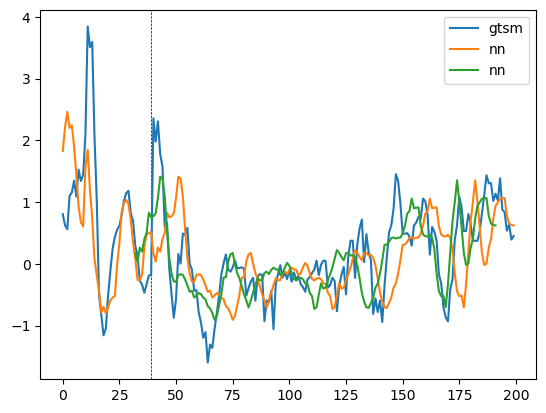

In [30]:
plt.figure()
plt.plot(gtsm_standardized[200:400],label='gtsm',zorder=1)
plt.plot(nn_standardized[200:400],label='nn',zorder=1)
plt.plot(np.arange(40,200)-8,nn_standardized[240:400],label='nn',zorder=1)
plt.axvline(x=39,zorder=0,linestyle='dashed',color='black',linewidth=.5)
plt.legend()

In [29]:
gtsm_standardized.time[200:400][39]

<xarray.DataArray 'time' ()>
array(cftime.Datetime360Day(1951, 1, 30, 21, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time                  object 1951-01-30 21:00:00
    station_x_coordinate  float64 4.739
    station_y_coordinate  float64 52.96
    lon                   float64 4.745
    lat                   float64 52.96
    tg                    <U29 'den_helder-denhdr-nld-rws.csv'
    i_lstm                float64 17.0
    it_lstm               float64 4.0
    year                  int64 1951
    month                 int64 1
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T

In [89]:
best_lags = []
for year in np.unique(gtsm_standardized.time.dt.year):
    
    corrs = []
    for k in np.arange(-15,15):
        corrs.append(np.corrcoef(gtsm_standardized[0+window*1000:1000+window*1000],nn_standardized[0+window*1000-k:1000+window*1000-k])[0][1])
    best_lags.append(np.arange(-20,20)[np.argmax(corrs)])

In [124]:
corrs = []

for month in np.unique(gtsm_standardized.time.dt.month):
    corrs.append(np.corrcoef(gtsm_standardized.isel(time=np.where(gtsm_standardized.time.dt.month==month)[0]),
                             nn_standardized.isel(time=np.where(nn_standardized.time.dt.month==month)[0]))[0][1])
    

In [8]:
best_lags = []
for month in np.unique(gtsm_standardized.time.dt.month):
    corrs = []
    for k in np.arange(-15,15):
        try:
            corrs.append(np.corrcoef(gtsm_standardized.isel(time=np.where(gtsm_standardized.time.dt.month==month)[0]),
                             nn_standardized.isel(time=np.where(nn_standardized.time.dt.month==month)[0]-k))[0][1])
        except:
            continue
    best_lags.append(np.arange(-15,15)[np.argmax(corrs)])


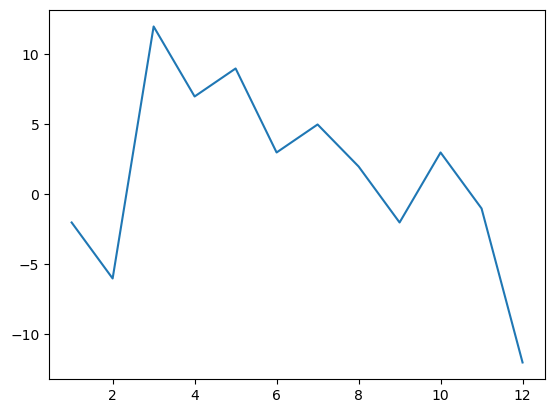

In [9]:
plt.plot(np.unique(gtsm_standardized.time.dt.month),best_lags)

array([  2623,   2624,   2625, ..., 283948, 283949, 283950])

In [10]:
np.corrcoef(gtsm_standardized,nn_standardized)

array([[1.        , 0.50009691],
       [0.50009691, 1.        ]])

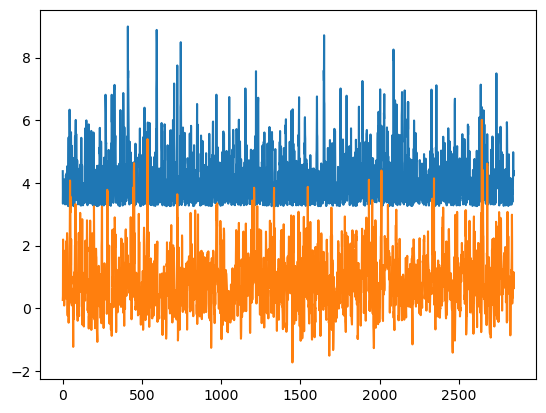

In [6]:
plt.plot(gtsm_standardized.where(gtsm_standardized>np.percentile(gtsm_standardized,99),drop=True).values)
plt.plot(nn_standardized.where(gtsm_standardized>np.percentile(gtsm_standardized,99),drop=True).values)

(-4.0, 6.0)

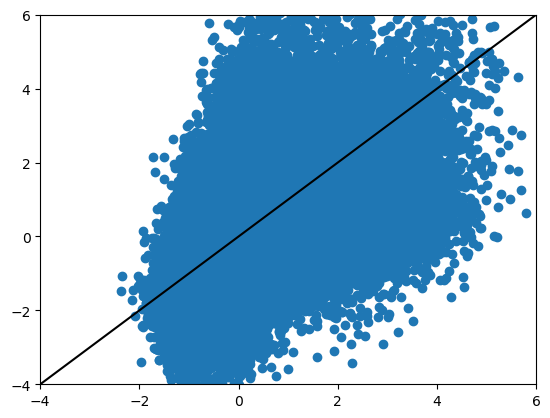

In [11]:
plt.scatter(nn_standardized,gtsm_standardized)
plt.plot([-4,6],[-4,6],zorder=2,color='black')
plt.xlim([-4,6])
plt.ylim([-4,6])

In [9]:
xr.corr(gtsm.sel(tg=tg_to_plot).surge,nn.sel(tg=tg_to_plot).surge,dim='time')

ValueError: cannot reindex or align along dimension 'time' because the (pandas) index has duplicate values

In [7]:
np.corrcoef(gtsm.sel(tg=tg_to_plot).surge.values[gtsm.sel(tg=tg_to_plot).surge.values>np.percentile(gtsm.sel(tg=tg_to_plot).surge.values,99)],
                                                nn.sel(tg=tg_to_plot).surge.values[gtsm.sel(tg=tg_to_plot).surge.values>np.percentile(gtsm.sel(tg=tg_to_plot).surge.values,99)])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 290870 but corresponding boolean dimension is 289656

In [6]:
np.percentile(gtsm.sel(tg=tg_to_plot).surge.values,q=99)

0.4320000112056732

In [9]:
gtsm.where(np.isfinite(gtsm.surge),drop=True).where(np.isfinite(gtsm.sel(tg=tg_to_plot).surge)==False,drop=True)

IndexError: dimension coordinate 'tg' conflicts between indexed and indexing objects:
<xarray.DataArray 'tg' (tg: 9)>
array(['alicante_i_outer_harbour-alio-esp-da_mm.csv',
       'brest-822a-fra-uhslc.csv', 'den_helder-denhdr-nld-rws.csv',
       'esbjerg-esb-dnk-dmi.csv', 'fishguard-fis-gbr-bodc.csv',
       'immingham-imm-gbr-bodc.csv', 'stavanger-svg-nor-nhs.csv',
       'vigo-vigo-esp-ieo.csv', 'wick-wic-gbr-bodc.csv'], dtype=object)
Coordinates:
    station_x_coordinate  (tg) float64 -0.476 -4.49 4.739 ... -8.738 -3.069
    station_y_coordinate  (tg) float64 38.33 48.38 52.96 ... 58.97 42.24 58.43
    lon                   (tg) float64 -0.4779 -4.495 4.745 ... -8.73 -3.086
    lat                   (tg) float64 38.34 48.38 52.96 ... 58.97 42.24 58.44
  * tg                    (tg) object 'alicante_i_outer_harbour-alio-esp-da_m...
    i_lstm                (tg) float64 21.0 15.0 17.0 22.0 ... 21.0 22.0 21.0
    it_lstm               (tg) float64 1.0 0.0 4.0 3.0 2.0 0.0 0.0 0.0 0.0
vs.
<xarray.Variable ()>
array('den_helder-denhdr-nld-rws.csv', dtype='<U29')

In [6]:
predictor_dir = 'gs://leap-persistent/timh37/HighResMIP/surgeNN_predictors/'
highresmip_model = 'HadGEM3-GC31-HM'
predictors = xr.open_dataset(os.path.join(predictor_dir,'predictors_'+highresmip_model+'_1950_2050_'+'den_helder-denhdr-nld-rws'+'.zarr'),engine='zarr')

In [96]:
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

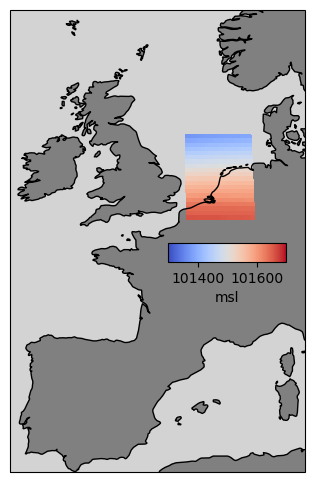

In [118]:
[LON,LAT] = np.meshgrid(predictors.longitude,predictors.latitude)
#plt.scatter(LON,LAT,c=predictors.isel(time=-23).u10,vmin=-8,vmax=8,cmap='coolwarm')

fig=plt.figure(figsize=(5,6)) #generate figure  
gs = fig.add_gridspec(1,1)
gs.update(hspace=.2)

ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.pcolor(LON,LAT,predictors.msl.mean(dim='time'),cmap='coolwarm',transform=ccrs.PlateCarree(),zorder=1,vmin=101300,vmax=101700) #colors

sc.set_edgecolor('face')
ax.coastlines(zorder=2,color='black')
ax.set_extent([-10, 10, 36, 63], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.56, .47,.4,.04),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='msl')

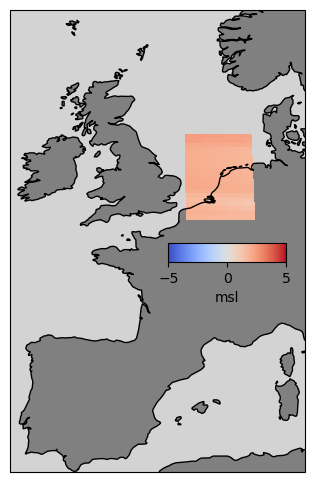

In [108]:
[LON,LAT] = np.meshgrid(predictors.longitude,predictors.latitude)
#plt.scatter(LON,LAT,c=predictors.isel(time=-23).u10,vmin=-8,vmax=8,cmap='coolwarm')

fig=plt.figure(figsize=(5,6)) #generate figure  
gs = fig.add_gridspec(1,1)
gs.update(hspace=.2)

ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.pcolor(LON,LAT,predictors.u10.mean(dim='time'),cmap='coolwarm',transform=ccrs.PlateCarree(),zorder=1,vmin=-5,vmax=5) #colors

sc.set_edgecolor('face')
ax.coastlines(zorder=2,color='black')
ax.set_extent([-10, 10, 36, 63], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.56, .47,.4,.04),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='msl')

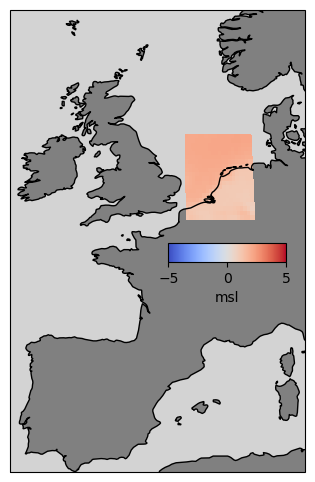

In [120]:
[LON,LAT] = np.meshgrid(predictors.longitude,predictors.latitude)
#plt.scatter(LON,LAT,c=predictors.isel(time=-23).u10,vmin=-8,vmax=8,cmap='coolwarm')

fig=plt.figure(figsize=(5,6)) #generate figure  
gs = fig.add_gridspec(1,1)
gs.update(hspace=.2)

ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.pcolor(LON,LAT,predictors_era5.u10.mean(dim='time'),cmap='coolwarm',transform=ccrs.PlateCarree(),zorder=1,vmin=-5,vmax=5) #colors

sc.set_edgecolor('face')
ax.coastlines(zorder=2,color='black')
ax.set_extent([-10, 10, 36, 63], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.56, .47,.4,.04),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='msl')

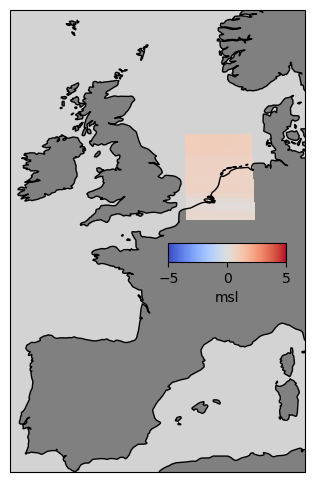

In [109]:
[LON,LAT] = np.meshgrid(predictors.longitude,predictors.latitude)
#plt.scatter(LON,LAT,c=predictors.isel(time=-23).u10,vmin=-8,vmax=8,cmap='coolwarm')

fig=plt.figure(figsize=(5,6)) #generate figure  
gs = fig.add_gridspec(1,1)
gs.update(hspace=.2)

ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.pcolor(LON,LAT,predictors.v10.mean(dim='time'),cmap='coolwarm',transform=ccrs.PlateCarree(),zorder=1,vmin=-5,vmax=5) #colors

sc.set_edgecolor('face')
ax.coastlines(zorder=2,color='black')
ax.set_extent([-10, 10, 36, 63], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.56, .47,.4,.04),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='msl')

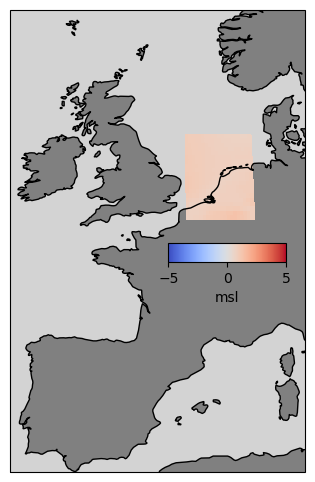

In [121]:
[LON,LAT] = np.meshgrid(predictors.longitude,predictors.latitude)
#plt.scatter(LON,LAT,c=predictors.isel(time=-23).u10,vmin=-8,vmax=8,cmap='coolwarm')

fig=plt.figure(figsize=(5,6)) #generate figure  
gs = fig.add_gridspec(1,1)
gs.update(hspace=.2)

ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.pcolor(LON,LAT,predictors_era5.v10.mean(dim='time'),cmap='coolwarm',transform=ccrs.PlateCarree(),zorder=1,vmin=-5,vmax=5) #colors

sc.set_edgecolor('face')
ax.coastlines(zorder=2,color='black')
ax.set_extent([-10, 10, 36, 63], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.56, .47,.4,.04),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='msl')

In [113]:
predictors_era5 = load_predictors('gs://leap-persistent/timh37/era5_predictors/3hourly','den_helder-denhdr-nld-rws.csv',5)

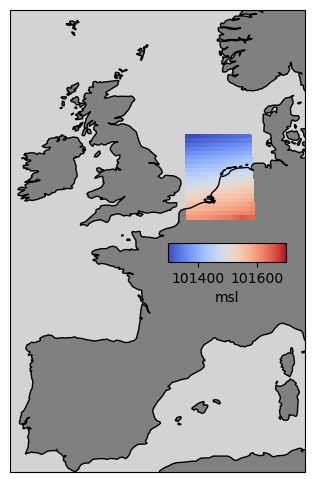

In [119]:
[LON,LAT] = np.meshgrid(predictors_era5.longitude,predictors_era5.latitude)
#plt.scatter(LON,LAT,c=predictors.isel(time=-23).u10,vmin=-8,vmax=8,cmap='coolwarm')

fig=plt.figure(figsize=(5,6)) #generate figure  
gs = fig.add_gridspec(1,1)
gs.update(hspace=.2)

ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.pcolor(LON,LAT,predictors_era5.msl.mean(dim='time'),cmap='coolwarm',transform=ccrs.PlateCarree(),zorder=1,vmin=101300,vmax=101700) #colors

sc.set_edgecolor('face')
ax.coastlines(zorder=2,color='black')
ax.set_extent([-10, 10, 36, 63], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.56, .47,.4,.04),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='msl')

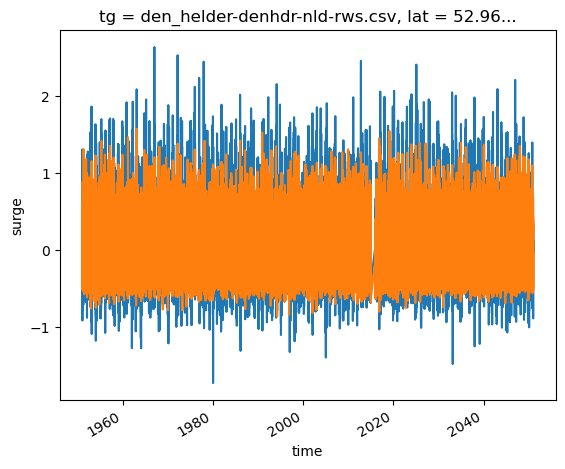

In [31]:
predictor_dir = 'gs://leap-persistent/timh37/HighResMIP/surgeNN_predictors/'
highresmip_model = 'HadGEM3-GC31-HM'
predictors = xr.open_dataset(os.path.join(predictor_dir,'predictors_'+highresmip_model+'_1950_2050_'+'den_helder-denhdr-nld-rws'+'.zarr'),engine='zarr')

In [32]:
predictors

<xarray.Dataset>
Dimensions:        (lat_around_tg: 20, lon_around_tg: 20, time: 290878)
Coordinates:
    height         float64 ...
  * lat_around_tg  (lat_around_tg) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
    latitude       (lat_around_tg) float64 ...
  * lon_around_tg  (lon_around_tg) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
    longitude      (lon_around_tg) float64 ...
    tg             <U49 ...
  * time           (time) object 1950-01-01 03:00:00 ... 2050-12-30 21:00:00
    variant_label  <U8 ...
Data variables:
    msl            (time, lat_around_tg, lon_around_tg) float32 ...
    u10            (time, lat_around_tg, lon_around_tg) float32 ...
    v10            (time, lat_around_tg, lon_around_tg) float32 ...
Attributes: (12/71)
    Conventions:                         CF-1.7 CMIP-6.0
    activity_id:                         HighResMIP
    branch_method:                       fixed historical forcing from 1950 w...
    branch_time_in_child:                0.0
    branch_time_in_parent:               10800.0
    cmor_version:                        3.2.4
    ...                                  ...
    table_info:                          Creation Date:(12 July 2017) MD5:634...
    tier:                                2
    title:                               HadGEM3-GC31-HM model output prepare...
    variable_id:                         vas
    variant_info:                        none
    variant_label:                       r1i1p1f1